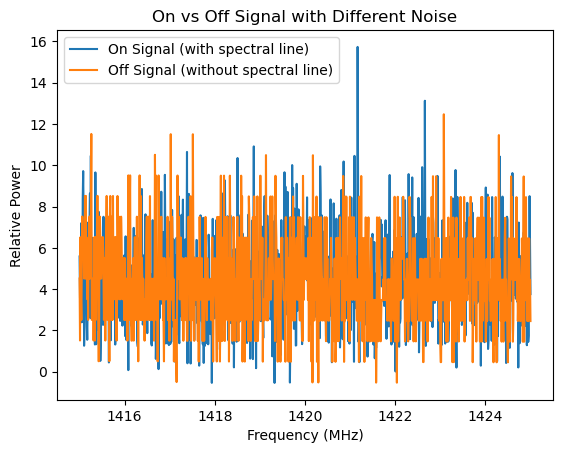

In [6]:
#We modified the code to model the spectral line as a Gaussian function with amplitude, mean, and standard deviation,which
#accounts for the realistic width.The spectral line is now modeled with this function:spectral_line = gaussian(frequency, amp=1, mu=1420, sigma=0.2)
#The noise for the "on" signal was modified to include an additional layer of random noise compared to the "off" signal. This change ensures that
#each signal has a different noise profile, simulating more realistic conditions. Specifically:
#off_noise = np.random.poisson(lam=5, size=num_samples)
#on_noise = np.random.poisson(lam=5, size=num_samples) + np.random.normal(0, 0.2, num_samples)

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline
from numpy.polynomial import Polynomial
from scipy.optimize import curve_fit

# Step 1: Simulating a radio signal with Poisson noise (Different noise for on/off signals)

# Parameters
num_samples = 1000
frequency = np.linspace(1415, 1425, num_samples)  # Frequency domain (MHz)

# Create a background signal (non-linear) and different Poisson noise for on/off
background_signal = np.sin(frequency / 1425 * 10)  # Background signal shape
off_noise = np.random.poisson(lam=5, size=num_samples)  # Poisson noise for off signal
on_noise = np.random.poisson(lam=5, size=num_samples) + np.random.normal(0, 0.2, num_samples)  # Different noise for on signal
off_signal = background_signal + off_noise

# Step 1b: Simulating the "on" signal with a spectral line modeled as a Gaussian
def gaussian(f, amp, mu, sigma):
    """ Gaussian function to simulate spectral line """
    return amp * np.exp(-0.5 * ((f - mu) / sigma)**2)

spectral_line = gaussian(frequency, amp=1, mu=1420, sigma=0.2)  # Gaussian spectral line at 1420 MHz
on_signal = background_signal + on_noise + spectral_line

# Visualize the "on" and "off" signals
plt.plot(frequency, on_signal, label='On Signal (with spectral line)')
plt.plot(frequency, off_signal, label='Off Signal (without spectral line)')
plt.title('On vs Off Signal with Different Noise')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative Power')
plt.legend()
plt.show()

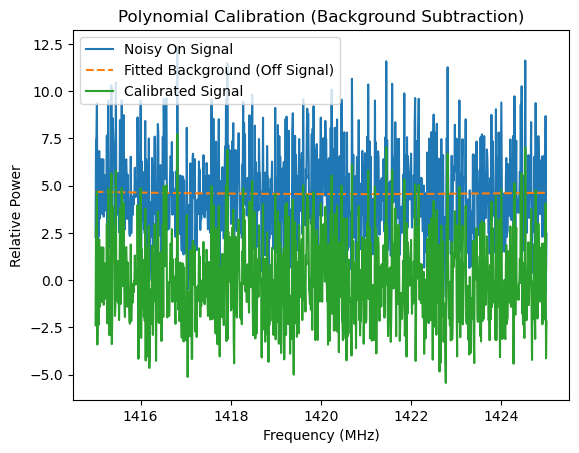

In [2]:
# Step 2: Background Calibration using Polynomial Fitting

# Polynomial fitting (degree 2)
p = Polynomial.fit(frequency, off_signal, deg=2)

# Subtracting the polynomial background from the noisy on-signal
calibrated_signal = on_signal - p(frequency)

# Visualize the calibrated signal
plt.plot(frequency, on_signal, label='Noisy On Signal')
plt.plot(frequency, p(frequency), label='Fitted Background (Off Signal)', linestyle='--')
plt.plot(frequency, calibrated_signal, label='Calibrated Signal')
plt.title('Polynomial Calibration (Background Subtraction)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative Power')
plt.legend()
plt.show()

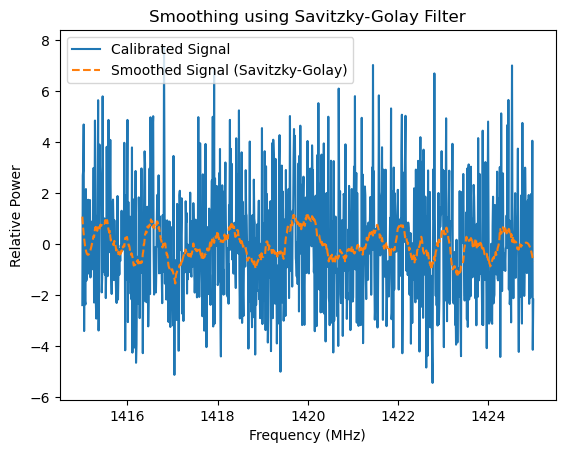

In [3]:
# Step 3: Smoothing using Savitzky-Golay Filter

# Applying Savitzky-Golay filter (window length = 51, polyorder = 3)
smooth_signal = savgol_filter(calibrated_signal, window_length=51, polyorder=3)

# Visualize the smoothed signal
plt.plot(frequency, calibrated_signal, label='Calibrated Signal')
plt.plot(frequency, smooth_signal, label='Smoothed Signal (Savitzky-Golay)', linestyle='--')
plt.title('Smoothing using Savitzky-Golay Filter')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative Power')
plt.legend()
plt.show()

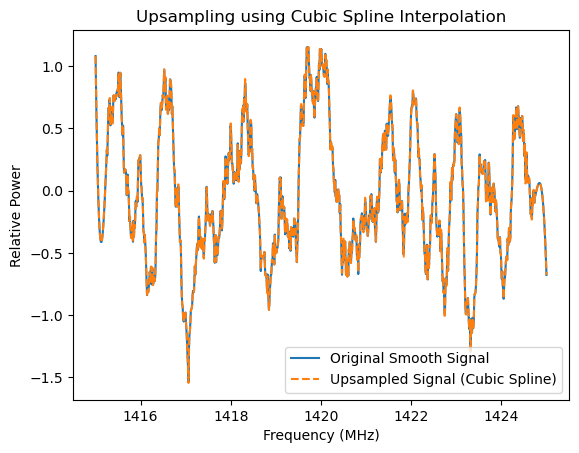

In [4]:
# Step 4: Upsampling using Cubic Spline Interpolation

# Cubic spline interpolation for upsampling
cs = CubicSpline(frequency, smooth_signal)

# New frequency domain for upsampling
new_num_samples = 2000
frequency_upsampled = np.linspace(1415, 1425, new_num_samples)
upsampled_signal = cs(frequency_upsampled)

# Visualize the upsampled signal
plt.plot(frequency, smooth_signal, label='Original Smooth Signal')
plt.plot(frequency_upsampled, upsampled_signal, label='Upsampled Signal (Cubic Spline)', linestyle='--')
plt.title('Upsampling using Cubic Spline Interpolation')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative Power')
plt.legend()
plt.show()

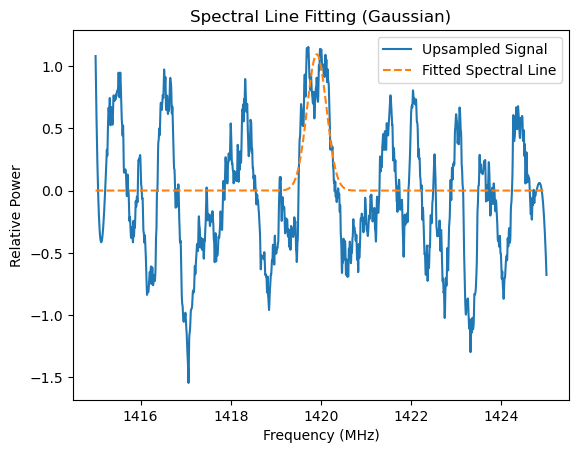

In [7]:

# Step 5: Spectral Line Fitting (Gaussian Fit example)

# Using the upsampled signal to fit the Gaussian spectral line
popt, _ = curve_fit(gaussian, frequency_upsampled, upsampled_signal, p0=[1, 1420, 0.2])

# Fitted spectral line
fitted_signal = gaussian(frequency_upsampled, *popt)

# Visualize the fitted signal
plt.plot(frequency_upsampled, upsampled_signal, label='Upsampled Signal')
plt.plot(frequency_upsampled, fitted_signal, label='Fitted Spectral Line', linestyle='--')
plt.title('Spectral Line Fitting (Gaussian)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative Power')
plt.legend()
plt.show()

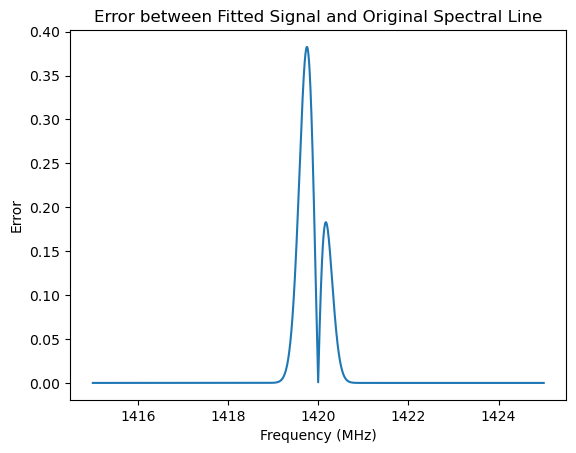

In [8]:
# Step 6: Error Estimation

# Calculate the error between the fitted signal and the original simulated spectral line
error = np.abs(fitted_signal - gaussian(frequency_upsampled, 1, 1420, 0.2))

# Visualize the error
plt.plot(frequency_upsampled, error)
plt.title('Error between Fitted Signal and Original Spectral Line')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Error')
plt.show()